# 2.3 공식문서 따라하면 실패하는 Agentic RAG

- 이번 회차에서는 `conditional_edge`를 활용하는 방법을 배웁니다
    - `conditional_edge는` `LangGraph`에서 조건부 실행 흐름을 제어하는 특별한 종류의 엣지입니다. 
    - 일반 `edge`와 달리, 특정 조건이 충족될 때만 해당 경로로 실행이 진행됩니다.
- `conditional_edge는`는 주로 'if-then' 형태의 로직을 구현할 때 사용됩니다. 
    - 사용자의 입력이 특정 조건을 만족할 때만 특정 `node`로 이동하고, 그렇지 않으면 다른 경로로 진행하도록 설정할 수 있습니다
    - 'if-then'과 다른점은, if-else문을 사용하지 않고, LLM의 판단에 따라 경로를 제어한다는 점입니다

- LangGraph 공식문서에 나온 흐름을 따라갑니다
    - 공식문서를 따라가면 `rewrite`를 정상적으로 하지 않아 "살짝" 변형합니다
![agentic-rag](https://i.imgur.com/9NCNGWa.png)

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection",
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

c:\dev2\AI_Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- `state`를 선언하고 에이전트를 생성합니다
- 2.2강과 같이 RAG 파이프라인 구성이 목적이기 때문에 동일한 `state`를 사용합니다

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str


graph_builder = StateGraph(AgentState)

In [3]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state["query"]  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {"context": docs}  # 검색된 문서를 포함한 state를 반환합니다.

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [5]:
from langchain import hub

# RAG 프롬프트를 가져옵니다.
generate_prompt = hub.pull("rlm/rag-prompt")


def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    context = state["context"]  # state에서 문맥을 추출합니다.
    query = state["query"]  # state에서 사용자의 질문을 추출합니다.

    # RAG 체인을 구성합니다.
    rag_chain = generate_prompt | llm

    # 질문과 문맥을 사용하여 응답을 생성합니다.
    response = rag_chain.invoke({"question": query, "context": context})

    return {"answer": response}  # 생성된 응답을 포함하는 state를 반환합니다.

- `conditional_edge`를 활용하여 문서 관련성을 판단하는 로직을 구현합니다
    - 에이전트는 LLM의 판단과 의사결정을 따릅니다

In [6]:
from langchain import hub
from typing import Literal

# 문서 관련성 판단을 위한 프롬프트를 가져옵니다.
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")


def check_doc_relevance(state: AgentState) -> Literal["generate", "rewrite"]:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite'를 반환합니다.
    """
    query = state["query"]  # state에서 사용자의 질문을 추출합니다.
    context = state["context"]  # state에서 문맥을 추출합니다.

    # 문서 관련성 판단 체인을 구성합니다.
    doc_relevance_chain = doc_relevance_prompt | llm

    # 질문과 문맥을 사용하여 문서의 관련성을 판단합니다.
    response = doc_relevance_chain.invoke({"question": query, "documents": context})

    # 관련성이 높으면 'generate'를 반환하고, 그렇지 않으면 'rewrite'를 반환합니다.
    if response["Score"] == 1:
        return "generate"

    return "rewrite"

In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 사전 정의: 특정 표현을 다른 표현으로 변환하기 위한 사전입니다.
dictionary = ["사람과 관련된 표현 -> 거주자"]

# 프롬프트 템플릿을 생성합니다. 사용자의 질문을 사전을 참고하여 변경합니다.
rewrite_prompt = PromptTemplate.from_template(
    f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
"""
)


def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state["query"]  # state에서 사용자의 질문을 추출합니다.

    # 리라이트 체인을 구성합니다. 프롬프트, LLM, 출력 파서를 연결합니다.
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    # 질문을 변경합니다.
    response = rewrite_chain.invoke({"query": query})

    return {"query": response}  # 변경된 질문을 포함하는 state를 반환합니다.

- `node`를 추가하고 `edge`로 연결합니다

In [8]:
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)

In [9]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges("retrieve", check_doc_relevance)
graph_builder.add_edge("rewrite", "retrieve")
graph_builder.add_edge("generate", END)

In [10]:
graph = graph_builder.compile()

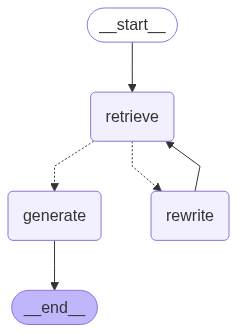

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

- 질문을 변경해보면서 `rewrite` 노드가 활성화되는지 확인해보세요

In [12]:
initial_state = {"query": "연봉 5천만원 세금"}
graph.invoke(initial_state)

{'query': '연봉 5천만원 세금',
 'context': [Document(id='e7058ba9-b1bd-4c9b-9488-e1f9d0193fd8', metadata={'source': 'C:\\dev2\\AI_Agent\\수업\\LangGraph를 활용한 AI Agent 개발(feat.MCP)\\Practice\\output_test\\income_tax.txt'}, page_content='| 종합소득 | 세   례 |\n|----------|-------|\n| 1,400만원 이하 | 과세표준의 6세역센트 |\n| 1,400만원 초과 | 84만원 + (1,400만원을 초과하는 금액의 15세역센트) |\n| 5,000만원 이하 | 624만원 + (5,000만원을 초과하는 금액의 24세역센트) |\n| 8,800만원 이하 | 1,536만원 + (8,800만원을 초과하는 금액의 35세역센트) |\n| 1억5천만원 이하 | 3,706만원 + (1억5천만원을 초과하는 금액의 38세역센트) |\n| 3억 원 이하 | 9,406만원 + (3억 원을 초과하는 금액의 40세역센트) |\n| 5억 원 이하 | 1억7,406만원 + (5억 원을 초과하는 금액의 42세역센트) |\n| 10억 원 이상  | 3억6,406만원 + (10억 원을 초과하는 금액의 45세역센트) |\n법제처 35\n국가법령정보센터'),
  Document(id='a64c3084-bfa6-4d24-bc82-4865af5ffdfa', metadata={'source': 'C:\\dev2\\AI_Agent\\수업\\LangGraph를 활용한 AI Agent 개발(feat.MCP)\\Practice\\output_test\\income_tax.txt'}, page_content='산입한다.\n제29조(퇴직급여충당금의 필요경비 계산) ① 사업자가 종업원의 퇴직급여에 충당하기 위하여 퇴직급여충당금을 \n필요경비로 계산한 경우에는 대출평형으로 정하는 범위에서 이를 해당 과세기간의 소득금액을 계산할 때 \

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection",
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str


graph_builder = StateGraph(AgentState)

def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state["query"]  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {"context": docs}  # 검색된 문서를 포함한 state를 반환합니다.
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

from langchain import hub

# RAG 프롬프트를 가져옵니다.
generate_prompt = hub.pull("rlm/rag-prompt")


def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    context = state["context"]  # state에서 문맥을 추출합니다.
    query = state["query"]  # state에서 사용자의 질문을 추출합니다.

    # RAG 체인을 구성합니다.
    rag_chain = generate_prompt | llm

    # 질문과 문맥을 사용하여 응답을 생성합니다.
    response = rag_chain.invoke({"question": query, "context": context})

    return {"answer": response}  # 생성된 응답을 포함하는 state를 반환합니다.

from langchain import hub
from typing import Literal

# 문서 관련성 판단을 위한 프롬프트를 가져옵니다.
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")


def check_doc_relevance(state: AgentState) -> Literal["generate", "rewrite"]:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite'를 반환합니다.
    """
    query = state["query"]  # state에서 사용자의 질문을 추출합니다.
    context = state["context"]  # state에서 문맥을 추출합니다.

    # 문서 관련성 판단 체인을 구성합니다.
    doc_relevance_chain = doc_relevance_prompt | llm

    # 질문과 문맥을 사용하여 문서의 관련성을 판단합니다.
    response = doc_relevance_chain.invoke({"question": query, "documents": context})

    # 관련성이 높으면 'generate'를 반환하고, 그렇지 않으면 'rewrite'를 반환합니다.
    if response["Score"] == 1:
        return "generate"

    return "rewrite"

from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 사전 정의: 특정 표현을 다른 표현으로 변환하기 위한 사전입니다.
dictionary = ["사람과 관련된 표현 -> 거주자"]

# 프롬프트 템플릿을 생성합니다. 사용자의 질문을 사전을 참고하여 변경합니다.
rewrite_prompt = PromptTemplate.from_template(
    f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
"""
)


def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state["query"]  # state에서 사용자의 질문을 추출합니다.

    # 리라이트 체인을 구성합니다. 프롬프트, LLM, 출력 파서를 연결합니다.
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    # 질문을 변경합니다.
    response = rewrite_chain.invoke({"query": query})

    return {"query": response}  # 변경된 질문을 포함하는 state를 반환합니다.

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)

from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges("retrieve", check_doc_relevance)
graph_builder.add_edge("rewrite", "retrieve")
graph_builder.add_edge("generate", END)


In [ ]:
from langchain_pinecone import PineconeVectorStore
from langchain_upstage import UpstageEmbeddings

embedding = UpstageEmbeddings(model="embedding-query")

vector_store = PineconeVectorStore.from_existing_index(
    index_name = "income-tax",
    embedding=embedding
)

from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

def retrieve(state: AgentState):
    query = state["query"]
    retriever = vector_store.as_retriever(search_kwargs={"k": 4})
    context = retriever.invoke(query)
    return {"context": context}

from langchain import hub
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState):
    query = state["query"]
    context = state["context"]
    generate_chain = generate_prompt | llm
    response = generate_chain.invoke({"question": query, "context": context})
    return {"answer": response}
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ["사람과 관련된 표현 -> 거주자"]

rewrite_prompt = PromptTemplate.from_template(
    f"""
    다음 문서를 보고 질문을 알맞게 수정해주세요.
    문서={dictionary}
    질문={{query}}
    """
)

def rewrite(state:AgentState):
    query = state["query"]
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({"query": query})
    return {"query": response}

from langchain import hub

check_doc_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState):
    query = state["query"]
    documents = state["context"]
    chain = check_doc_prompt | llm
    response = chain.invoke({"documents": documents,"question": query})
    
    if response["Score"] == 1:
        return "generate"

    return "rewrite"

from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(AgentState)

graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)

graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges("retrieve", check_doc_relevance)
graph_builder.add_edge("rewrite", "retrieve")
graph_builder.add_edge("generate", END)